In [1]:
import pandas as pd
import unicodedata
import json
import json
from datetime import date


In [2]:
# Función para normalizar nombres de canciones (quita espacios extra y pasa a minúsculas)
def normalize(song):
    song = song.strip().lower()
    song = ''.join(c for c in unicodedata.normalize('NFKD', song) if not unicodedata.combining(c) or c == 'ñ')
    return song


In [3]:
# Cargar los archivos JSON
with open(r'C:\Users\Yo\Desktop\setlist\SetlistFM-Setlist-Evolution\album_data\Los Piojos.json', 'r', encoding='utf-8') as f:
    albums_data = json.load(f)


with open('Setlists_Piojos.json', 'r', encoding='utf-8') as f:
    setlists_data = json.load(f)

In [4]:

# Crear diccionarios para mapear cada canción a su álbum y a su color
song_to_album = {}
song_to_color = {}
for album in albums_data.get("albums", []):
    album_title = album.get("title", "Ineditos")
    color = album.get("color", "gray")
    for track in album.get("tracks", []):
        norm_track = normalize(track)
        # Si la canción aparece en varios álbumes, se asigna el primero encontrado
        if norm_track not in song_to_album:
            song_to_album[norm_track] = album_title
            song_to_color[norm_track] = color

# Crear un diccionario que mapea cada álbum a su color en formato HEX
album_to_color = {}
for album in albums_data.get("albums", []):
    album_to_color[album.get("title", "Ineditos")] = album.get("color", "#39df00")

In [5]:

df_popularidad = pd.read_excel(r'C:\Users\Yo\Desktop\setlist\SetlistFM-Setlist-Evolution\canciones_popularidad.xlsx')


# Ordenar los setlists por fecha (usando year, month, day)
setlists_data.sort(key=lambda s: date(s["year"], s["month"], s["day"]))

# Procesar cada setlist y contar acumulativamente
records = []
cumulative_counts = {}

for setlist in setlists_data:
    # Crear fecha en formato ISO
    current_date = date(setlist["year"], setlist["month"], setlist["day"]).isoformat()
    place = setlist["venue"]
    # Procesar la lista de canciones, separando por "/" si es necesario
    canciones_raw = setlist.get("songs", [])
    canciones = []
    for item in canciones_raw:
        for part in item.split('/'):
            if part.strip():
                canciones.append(part.strip())
    
    # Actualizar los conteos acumulados
    for song in canciones:
        norm_song = normalize(song)
        cumulative_counts[norm_song] = cumulative_counts.get(norm_song, 0) + 1
    # Registrar el estado acumulado hasta la fecha actual
    for song, count in cumulative_counts.items():
        album = song_to_album.get(song, "Ineditos")
        color = song_to_color.get(song, "#000000")
        records.append({
            "fecha": current_date,
            "lugar": place,
            "canción": song.title(),  # Capitalizamos para visualización
            "álbum": album,
            "color": color,
            "veces_tocada": count
        })

# Crear DataFrame y agrupar para quedarnos con el último conteo de cada fecha
df_vuelta_total = pd.DataFrame(records)


df_vuelta_total[df_vuelta_total['fecha'] == '2025-05-25'].head()

# Asume que song_to_album y song_to_color ya están definidos


all_records = []

for setlist in setlists_data:
    current_date = date(setlist["year"], setlist["month"], setlist["day"]).isoformat()
    place = setlist["venue"]
    canciones_raw = setlist.get("songs", [])
    canciones = []
    for item in canciones_raw:
        for part in item.split('/'):
            if part.strip():
                canciones.append(part.strip())
    for song in canciones:
        norm_song = normalize(song)
        album = song_to_album.get(norm_song, "Ineditos")
        color = song_to_color.get(norm_song, "#000000")
        all_records.append({
            "fecha": current_date,
            "lugar": place,
            "canción": song.title(),
            "álbum": album,
            "color": color  # Solo cuenta 1 para este concierto
        })

# Super DataFrame con todas las fechas y canciones (sin acumulativo)
df_super = pd.DataFrame(all_records)

df_super

,fecha,lugar,canción,álbum,color
0,1991-09-21,"Boa Vista, Buenos Aires, Argentina",Blues Del Gato Sarnoso,Ineditos,#d57f5c
1,1991-09-21,"Boa Vista, Buenos Aires, Argentina",Los Mocosos,Chac Tu Chac,#1e2830
2,1991-09-21,"Boa Vista, Buenos Aires, Argentina",Blues Del Traje Gris,Chac Tu Chac,#1e2830
3,1991-09-21,"Boa Vista, Buenos Aires, Argentina",Chac Tu Chac,Chac Tu Chac,#1e2830
4,1991-09-21,"Boa Vista, Buenos Aires, Argentina",Babilonia,Ay Ay Ay,#c41616
...,...,...,...,...,...
4100,2025-05-25,"Parque de la Ciudad, Buenos Aires, Argentina",El Farolito,3er Arco,#ead936
4101,2025-05-25,"Parque de la Ciudad, Buenos Aires, Argentina",El Balneario De Los Doctores Crotos,Azul,#0047a5
4102,2025-05-25,"Parque de la Ciudad, Buenos Aires, Argentina",Cruel,Chac Tu Chac,#1e2830
4103,2025-05-25,"Parque de la Ciudad, Buenos Aires, Argentina",Finale,Azul,#0047a5


In [6]:
df_super['cancion_norm'] = df_super['canción'].apply(normalize)
df_popularidad['cancion_norm'] = df_popularidad['canción'].apply(normalize)

In [7]:

# 2. Une la popularidad a cada canción tocada en cada concierto
df_super = df_super.merge(
    df_popularidad[['cancion_norm', 'indice_popularidad', 'indice_popularidad_norm']],
    on='cancion_norm',
    how='left'
)

df_super

,fecha,lugar,canción,álbum,color,cancion_norm,indice_popularidad,indice_popularidad_norm
0,1991-09-21,"Boa Vista, Buenos Aires, Argentina",Blues Del Gato Sarnoso,Ineditos,#d57f5c,blues del gato sarnoso,-0.787491,0.061883
1,1991-09-21,"Boa Vista, Buenos Aires, Argentina",Los Mocosos,Chac Tu Chac,#1e2830,los mocosos,-0.108193,0.235819
2,1991-09-21,"Boa Vista, Buenos Aires, Argentina",Blues Del Traje Gris,Chac Tu Chac,#1e2830,blues del traje gris,-0.489090,0.138290
3,1991-09-21,"Boa Vista, Buenos Aires, Argentina",Chac Tu Chac,Chac Tu Chac,#1e2830,chac tu chac,0.019795,0.268590
4,1991-09-21,"Boa Vista, Buenos Aires, Argentina",Babilonia,Ay Ay Ay,#c41616,babilonia,0.204522,0.315890
...,...,...,...,...,...,...,...,...
4100,2025-05-25,"Parque de la Ciudad, Buenos Aires, Argentina",El Farolito,3er Arco,#ead936,el farolito,2.600115,0.929285
4101,2025-05-25,"Parque de la Ciudad, Buenos Aires, Argentina",El Balneario De Los Doctores Crotos,Azul,#0047a5,el balneario de los doctores crotos,0.658090,0.432027
4102,2025-05-25,"Parque de la Ciudad, Buenos Aires, Argentina",Cruel,Chac Tu Chac,#1e2830,cruel,0.159382,0.304332
4103,2025-05-25,"Parque de la Ciudad, Buenos Aires, Argentina",Finale,Azul,#0047a5,finale,0.146156,0.300945


In [8]:
# 3. Calcula el promedio de popularidad por concierto (por fecha)
df_conciertos = df_super.groupby('fecha')['indice_popularidad_norm'].mean().reset_index()
df_conciertos = df_conciertos.sort_values('indice_popularidad_norm', ascending=False)


# 4. Ahora puedes ver los conciertos más "mainstream" y más "alternativos"
print("Recitales ordenados de mayor a menor popularidad en promedio:")
print(df_conciertos.sort_values('indice_popularidad_norm', ascending=False))

Recitales ordenados de mayor a menor popularidad en promedio:
          fecha  indice_popularidad_norm
138  2008-05-01                 0.885572
91   2004-10-10                 0.793305
160  2009-03-26                 0.655949
113  2007-05-06                 0.596631
145  2008-06-14                 0.573115
..          ...                      ...
5    1994-08-06                 0.284987
3    1993-07-09                 0.229025
2    1992-11-14                 0.224915
1    1991-11-09                 0.213641
0    1991-09-21                 0.195510

[178 rows x 2 columns]


In [9]:
# Filtrar fechas donde se hayan tocado más de 10 temas
fechas_mas_10 = df_super['fecha'].value_counts()
fechas_validas = fechas_mas_10[fechas_mas_10 > 15].index
df_super = df_super[df_super['fecha'].isin(fechas_validas)]
velez = df_super[df_super['fecha'] == '2004-05-22']
velez['indice_popularidad_norm'].median()

0.3058366526768369

In [10]:

# 3. Calcula el promedio de popularidad por concierto (por fecha)
df_conciertos = df_super.groupby(['fecha', 'lugar'])['indice_popularidad_norm'].mean().reset_index()
df_conciertos = df_conciertos.sort_values('indice_popularidad_norm', ascending=False)
df_conciertos = df_conciertos[df_conciertos['fecha'] > '2000-06-10']
df_conciertos = df_conciertos.sort_values(by= 'indice_popularidad_norm', ascending= False)
# 4. Ahora puedes ver los conciertos más "mainstream" y más "alternativos"
print("Recitales ordenados de mayor a menor popularidad en promedio:")
print(df_conciertos)

Recitales ordenados de mayor a menor popularidad en promedio:
          fecha                                              lugar  \
108  2007-11-17  Estadio Abierto del Parque de Mayo, San Juan, ...   
131  2008-11-15  Anfiteatro Mario del Tránsito Cocomarola, Corr...   
120  2008-05-02              Sala Assaig, Palma de Mallorca, Spain   
133  2008-11-22  Monumento al Obrero Petrolero, Caleta Olivia, ...   
112  2007-12-11               Estadio Ruca Che, Neuquén, Argentina   
..          ...                                                ...   
88   2006-04-26         Estadio Luna Park, Buenos Aires, Argentina   
34   2000-07-16  Estadio Obras Sanitarias, Buenos Aires, Argentina   
83   2005-10-01                 Estadio Unión, Santa Fe, Argentina   
85   2005-12-22      Estadio Boca Juniors, Buenos Aires, Argentina   
72   2004-05-22   Estadio Vélez Sarsfield, Buenos Aires, Argentina   

     indice_popularidad_norm  
108                 0.562223  
131                 0.558008  
120 

In [11]:
df_conciertos.to_excel('recitales_ordenados_por_popularidad.xlsx', index = False)

In [12]:
# Filtrar df_super para excluir canciones del álbum "Ineditos"
df_super_sin_ineditos = df_super[df_super['álbum'] != 'Ineditos']

# Calcular el promedio de popularidad por concierto (fecha y lugar) sin inéditos
df_conciertos_sin_ineditos = df_super_sin_ineditos.groupby(['fecha', 'lugar'])['indice_popularidad_norm'].mean().reset_index()
df_conciertos_sin_ineditos = df_conciertos_sin_ineditos[df_conciertos_sin_ineditos['fecha'] > '1997-02-10']
df_conciertos_sin_ineditos.sort_values(by= 'indice_popularidad_norm', ascending= False).tail(27)

,fecha,lugar,indice_popularidad_norm
70,2004-01-30,"Patinódromo Municipal, Mar del Plata, Argentina",0.373043
27,1999-12-18,"Estadio Atlanta, Buenos Aires, Argentina",0.372201
93,2006-08-25,"Estadio Luna Park, Buenos Aires, Argentina",0.371743
26,1999-10-09,"Estadio All Boys, Buenos Aires, Argentina",0.370620
154,2025-05-24,"Parque de la Ciudad, Buenos Aires, Argentina",0.369988
86,2005-12-23,"Estadio Boca Juniors, Buenos Aires, Argentina",0.369546
90,2006-04-29,"Estadio Luna Park, Buenos Aires, Argentina",0.369146
92,2006-08-24,"Estadio Luna Park, Buenos Aires, Argentina",0.368913
24,1999-05-09,"Estadio Obras Sanitarias, Buenos Aires, Argentina",0.368571
22,1999-05-07,"Estadio Obras Sanitarias, Buenos Aires, Argentina",0.367862


In [13]:
df_conciertos_sin_ineditos[['Lugar', 'Localidad', 'País']] = df_conciertos_sin_ineditos['lugar'].str.split(',', expand=True)

df_conciertos_sin_ineditos[['Año', 'Mes', 'Día']] = df_conciertos_sin_ineditos['fecha'].str.split('-', expand=True)

In [14]:
df_conciertos_sin_ineditos

,fecha,lugar,indice_popularidad_norm,Lugar,Localidad,País,Año,Mes,Día
15,1997-03-29,"Costa Chaval, Concordia, Argentina",0.378780,Costa Chaval,Concordia,Argentina,1997,03,29
16,1997-07-18,"Microestadio Racing Club, Avellaneda, Argentina",0.358387,Microestadio Racing Club,Avellaneda,Argentina,1997,07,18
17,1997-07-19,"Microestadio Racing Club, Avellaneda, Argentina",0.367850,Microestadio Racing Club,Avellaneda,Argentina,1997,07,19
18,1998-05-17,"Parque Sarmiento, Buenos Aires, Argentina",0.354167,Parque Sarmiento,Buenos Aires,Argentina,1998,05,17
19,1998-08-22,Polideportivo Club de Gimnasia y Esgrima La Pl...,0.336848,Polideportivo Club de Gimnasia y Esgrima La Plata,La Plata,Argentina,1998,08,22
...,...,...,...,...,...,...,...,...,...
151,2025-04-26,"Hipódromo Parque de La Independencia, Rosario,...",0.466426,Hipódromo Parque de La Independencia,Rosario,Argentina,2025,04,26
152,2025-05-03,"Teatro Griego Frank Romero Day, Mendoza, Argen...",0.474947,Teatro Griego Frank Romero Day,Mendoza,Argentina,2025,05,03
153,2025-05-10,"Playón Mario Alberto Kempes, Córdoba, Argentina",0.486439,Playón Mario Alberto Kempes,Córdoba,Argentina,2025,05,10
154,2025-05-24,"Parque de la Ciudad, Buenos Aires, Argentina",0.369988,Parque de la Ciudad,Buenos Aires,Argentina,2025,05,24


In [15]:
df_conciertos_sin_ineditos['lugar'].unique()

array(['Costa Chaval, Concordia, Argentina',
       'Microestadio Racing Club, Avellaneda, Argentina',
       'Parque Sarmiento, Buenos Aires, Argentina',
       'Polideportivo Club de Gimnasia y Esgrima La Plata, La Plata, Argentina',
       'Estadio All Boys, Buenos Aires, Argentina',
       'Autocine Villa Gesell, Villa Gesell, Argentina',
       'Estadio Obras Sanitarias, Buenos Aires, Argentina',
       'Estadio Atlanta, Buenos Aires, Argentina',
       'Plaza Moreno, La Plata, Argentina',
       'Estadio Universidad Tecnológica, Santa Fe, Argentina',
       'Estadio General Paz Juniors, Córdoba, Argentina',
       'Estadio Polideportivo Islas Malvinas, Mar del Plata, Argentina',
       'Plaza Próspero Molina, Cosquín, Argentina',
       'El Sitio, Galvez, Argentina',
       'Estadio Abierto del Parque de Mayo, San Juan, Argentina',
       'Estadio Pacífico, Mendoza, Argentina',
       'Coliseo de la Quebrada, La Rioja, Argentina',
       'Gimnasio Cubierto ICM, Chascomús, Argenti

In [16]:
aforos = {
    'Costa Chaval, Concordia, Argentina': 1500,
    'Microestadio Racing Club, Avellaneda, Argentina': 3500,
    'Parque Sarmiento, Buenos Aires, Argentina': 20000,
    'Polideportivo Club de Gimnasia y Esgrima La Plata, La Plata, Argentina': 3000,
    'Estadio All Boys, Buenos Aires, Argentina': 21000,
    'Autocine Villa Gesell, Villa Gesell, Argentina': 5000,
    'Estadio Obras Sanitarias, Buenos Aires, Argentina': 4700,
    'Estadio Atlanta, Buenos Aires, Argentina': 34000,
    'Plaza Moreno, La Plata, Argentina': 20000,
    'Estadio Universidad Tecnológica, Santa Fe, Argentina': 5000,
    'Estadio General Paz Juniors, Córdoba, Argentina': 11000,
    'Estadio Polideportivo Islas Malvinas, Mar del Plata, Argentina': 7500,
    'Plaza Próspero Molina, Cosquín, Argentina': 10000,
    'El Sitio, Galvez, Argentina': 1000,
    'Estadio Abierto del Parque de Mayo, San Juan, Argentina': 8000,
    'Estadio Pacífico, Mendoza, Argentina': 5000,
    'Coliseo de la Quebrada, La Rioja, Argentina': 7000,
    'Gimnasio Cubierto ICM, Chascomús, Argentina': 2000,
    'Acrópolis Megadisco, San Salvador de Jujuy, Argentina': 1500,
    'Club Bomberos Voluntarios, Bariloche, Argentina': 2000,
    'Estadio Huracán, Buenos Aires, Argentina': 48000,
    'Balneario Don Roque, Sauce Viejo, Argentina': 3000,
    'Anfiteatro del Río Uruguay, Paysandú, Uruguay': 5000,
    'Pajas Blancas Center, Córdoba, Argentina': 2000,
    'Estadio Villa Luján, San Miguel de Tucumán, Argentina': 5000,
    'Estadio Luna Park, Buenos Aires, Argentina': 8000,
    'Estadio Socio Fundadores, Comodoro Rivadavia, Argentina': 3500,
    'Estadio Roberto Carminatti, Bahía Blanca, Argentina': 18000,
    "Estadio Cubierto Newell's Old Boys, Rosario, Argentina": 8000,
    'Sala Assaig, Palma de Mallorca, Spain': 1000,
    'Patinódromo Municipal, Mar del Plata, Argentina': 6000,
    'La Vieja Usina, Córdoba, Argentina': 1200,
    'Estadio River Plate, Buenos Aires, Argentina': 70000,
    'Estadio Vélez Sarsfield, Buenos Aires, Argentina': 50000,
    'Orfeo Superdomo, Córdoba, Argentina': 14000,
    'Estación Jujuy, San Salvador de Jujuy, Argentina': 2000,
    'Gimnasio Don Bosco, Río Grande, Argentina': 1500,
    'Club Ingeniero Huergo, Comodoro Rivadavia, Argentina': 2000,
    'Estadio Delmi, Salta, Argentina': 10000,
    'Estadio Ferrocarril Oeste, Buenos Aires, Argentina': 24000,
    'Estadio Ciudad de La Plata, La Plata, Argentina': 53000,
    'Estadio Unión, Santa Fe, Argentina': 28000,
    'Obras Sanitarias Outdoor, Buenos Aires, Argentina': 8000,
    'Estadio Boca Juniors, Buenos Aires, Argentina': 49000,
    'El Santo Disco, Rodeo del Medio, Argentina': 1500,
    'Anfiteatro Villa María, Villa María, Argentina': 11000,
    'Boxing Club, Río Gallegos, Argentina': 2500,
    'Estadio Cayetano Castro, Trelew, Argentina': 8000,
    'Club Estudiantes de Olavarría, Olavarría, Argentina': 2000,
    'Hipódromo Parque de La Independencia, Rosario, Argentina': 30000,
    'Estadio Juniors, Córdoba, Argentina': 6000,
    'Estadio Central Córdoba, San Miguel de Tucumán, Argentina': 25000,
    'Estadio La Tablada, San Salvador de Jujuy, Argentina': 5000,
    'Corporación del Comercio, Bahía Blanca, Argentina': 1000,
    'Estadio Ruca Che, Neuquén, Argentina': 8500,
    'Comuna San Roque, Cosquín, Argentina': 2000,
    'Willie Dixon, Rosario, Argentina': 1200,
    'Estadio Chateau Carreras, Córdoba, Argentina': 57000,
    'Razzmatazz, Barcelona, Spain': 2000,
    'Alcatraz, Milan, Italy': 3000,
    'Anfiteatro Mario del Tránsito Cocomarola, Corrientes, Argentina': 15000,
    'Monumento al Obrero Petrolero, Caleta Olivia, Argentina': 20000,
    'Aeródromo Santa María de Punilla, Santa Maria de Punilla, Argentina': 60000,
    'Tecnópolis, Villa Martelli, Argentina': 80000,
    'Teatro Griego Frank Romero Day, Mendoza, Argentina': 20000,
    'Playón Mario Alberto Kempes, Córdoba, Argentina': 30000,
    'Parque de la Ciudad, Buenos Aires, Argentina': 50000,
}

df_conciertos_sin_ineditos['aforo'] = df_conciertos_sin_ineditos['lugar'].map(aforos)
    

In [17]:
# ...existing code...

# Definí las zonas según tus criterios
bsas = ['Buenos Aires', 'Villa Martelli', 'Avellaneda']
interior_bsas = [
    'La Plata', 'Villa Gesell' , 'Mar del Plata' , 'Chascomús', 'Bahía Blanca', 'Olavarría']

interior = ['Santa Fe', 'Córdoba', 'Cosquín', 'Galvez', 'San Juan',
    'Mendoza', 'Sauce Viejo', 'Rosario',
    'Rodeo del Medio', 'Villa María',   
    'Caleta Olivia', 'Santa Maria de Punilla', 'Concordia']

interior_sur = ['Bariloche', 'Río Grande', 'Comodoro Rivadavia','Río Gallegos', 'Trelew', 'Neuquén']
interior_norte = ['Corrientes', 'La Rioja', 'San Salvador de Jujuy', 'San Miguel de Tucumán',  'Salta']
exterior = ['Paysandú', 'Palma de Mallorca', 'Barcelona', 'Milan']

def clasificar_zona(localidad):
    localidad = localidad.strip()
    if localidad in bsas:
        return 'Buenos Aires'
    elif localidad in interior_bsas:
        return 'Interior Buenos Aires'
    elif localidad in interior:
        return 'Interior'
    elif localidad in interior_sur:
        return 'Interior Sur'
    elif localidad in interior_norte:
        return 'Interior Norte'
    elif localidad in exterior:
        return 'Exterior'
    else:
        return 'Otra'
    


df_conciertos_sin_ineditos['Zona'] = df_conciertos_sin_ineditos['Localidad'].apply(clasificar_zona)
df_conciertos_sin_ineditos['Zona'] = df_conciertos_sin_ineditos['Zona'].astype('category')

# Ahora la columna 'Zona' es categórica y podés usarla para análisis o gráficos
df_conciertos_sin_ineditos['Zona'].value_counts()


Zona
Buenos Aires             52
Interior                 39
Interior Buenos Aires    27
Interior Sur             10
Interior Norte            8
Exterior                  5
Name: count, dtype: int64

In [18]:
df_conciertos_sin_ineditos.select_dtypes(include='number').corr()

,indice_popularidad_norm,aforo
indice_popularidad_norm,1.000000,-0.045461
aforo,-0.045461,1.000000


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
import numpy as np

# seteamos vars para predecir popularidad 


# Función para categorizar el día en quincena
def quincena_from_day(dias):
    # dias puede ser una Serie o array de strings o ints
    dias = dias.astype(int)
    return np.where(dias <= 15, '1', '2').reshape(-1, 1)

# Suponiendo que el DataFrame de entrada es df_conciertos_sin_ineditos
# y tiene las columnas 'Día', 'aforo', 'Localidad', 'indice_popularidad_norm'

# Preparamos las features
X = df_conciertos_sin_ineditos[['Día', 'aforo', 'Localidad']]
y = df_conciertos_sin_ineditos['indice_popularidad_norm']

# Preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('quincena', FunctionTransformer(quincena_from_day, feature_names_out='one-to-one'), ['Día']),
        ('aforo', 'passthrough', ['aforo']),
        ('localidad', OneHotEncoder(drop='first', sparse_output=False), ['Localidad'])
    ],
    remainder='drop'
)

# Pipeline
pipeline = Pipeline([
    ('pre', preprocessor),
    ('reg', RandomForestRegressor(random_state=42))
])

# Entrenar el pipeline
pipeline.fit(X, y)



Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('quincena',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function quincena_from_day at 0x0000026B072AFBA0>),
                                                  ['Día']),
                                                 ('aforo', 'passthrough',
                                                  ['aforo']),
                                                 ('localidad',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Localidad'])])),
                ('reg', RandomForestRegressor(random_state=42))])

In [20]:
# Evaluar el modelo
from sklearn.metrics import mean_squared_error, r2_score
y_pred = pipeline.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 0.0006806220392995918
R^2 Score: 0.7813045344130563


In [21]:
# escala de la variable objetivo

df_conciertos_sin_ineditos['indice_popularidad_norm'].describe()

count    141.000000
mean       0.430426
std        0.055986
min        0.322628
25%        0.385355
50%        0.428116
75%        0.464774
max        0.579356
Name: indice_popularidad_norm, dtype: float64

In [22]:
import pandas as pd
import json

# Cargar el JSON
with open('Setlists_Piojos.json', 'r', encoding='utf-8') as f:
    setlists_data = json.load(f)

# Convertir a DataFrame
df_setlists = pd.DataFrame(setlists_data)

# Crear columna de fecha para mergear (asegurate que el formato coincida con tu df principal)
df_setlists['fecha'] = df_setlists.apply(lambda row: f"{row['year']}-{row['month']:02d}-{row['day']:02d}", axis=1)
df_setlists['lugar'] = df_setlists['venue']

# Dejá solo las columnas que te interesan
df_setlists = df_setlists[['fecha', 'lugar', 'songs']].rename(columns={'songs': 'canciones_show'})

# Mergeá con tu DataFrame principal (por fecha y lugar)
df_conciertos_sin_ineditos = df_conciertos_sin_ineditos.merge(df_setlists, on=['fecha', 'lugar'], how='left')


In [23]:
df_conciertos_sin_ineditos['cantidad_canciones'] = df_conciertos_sin_ineditos['canciones_show'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_conciertos_sin_ineditos

,fecha,lugar,indice_popularidad_norm,Lugar,Localidad,País,Año,Mes,Día,aforo,Zona,canciones_show,cantidad_canciones
0,1997-03-29,"Costa Chaval, Concordia, Argentina",0.378780,Costa Chaval,Concordia,Argentina,1997,03,29,1500,Interior,"[Ximenita, Taxi Boy, Babilonia, Ay ay ay, Gris...",26
1,1997-07-18,"Microestadio Racing Club, Avellaneda, Argentina",0.358387,Microestadio Racing Club,Avellaneda,Argentina,1997,07,18,3500,Buenos Aires,"[Arco, Babilonia, Ay ay ay, Gris, Angelito, Ge...",23
2,1997-07-19,"Microestadio Racing Club, Avellaneda, Argentina",0.367850,Microestadio Racing Club,Avellaneda,Argentina,1997,07,19,3500,Buenos Aires,"[Chac tu chac, Ximenita, Taxi Boy, Gris, Muy d...",24
3,1998-05-17,"Parque Sarmiento, Buenos Aires, Argentina",0.354167,Parque Sarmiento,Buenos Aires,Argentina,1998,05,17,20000,Buenos Aires,"[Yira yira, Babilonia, Taxi Boy, Vals inicial,...",26
4,1998-08-22,Polideportivo Club de Gimnasia y Esgrima La Pl...,0.336848,Polideportivo Club de Gimnasia y Esgrima La Plata,La Plata,Argentina,1998,08,22,3000,Interior Buenos Aires,"[Babilonia, Yira yira, Desde lejos no se ve, T...",26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,2025-04-26,"Hipódromo Parque de La Independencia, Rosario,...",0.466426,Hipódromo Parque de La Independencia,Rosario,Argentina,2025,04,26,30000,Interior,"[Llévatelo, María y José, Desde lejos no se ve...",28
137,2025-05-03,"Teatro Griego Frank Romero Day, Mendoza, Argen...",0.474947,Teatro Griego Frank Romero Day,Mendoza,Argentina,2025,05,03,20000,Interior,"[Ruleta, Arco, Yira yira, Vine hasta aquí, Civ...",31
138,2025-05-10,"Playón Mario Alberto Kempes, Córdoba, Argentina",0.486439,Playón Mario Alberto Kempes,Córdoba,Argentina,2025,05,10,30000,Interior,"[Fantasma, Desde lejos no se ve, Ruleta, Civil...",29
139,2025-05-24,"Parque de la Ciudad, Buenos Aires, Argentina",0.369988,Parque de la Ciudad,Buenos Aires,Argentina,2025,05,24,50000,Buenos Aires,"[Unbekannt, El balneario de los doctores croto...",30


In [24]:
# Definí qué es un "hit" (top 25% más populares)
umbral_hit = df_popularidad['indice_popularidad_norm'].quantile(0.75)
hits = set(df_popularidad[df_popularidad['indice_popularidad_norm'] >= umbral_hit]['cancion_norm'])

def proporcion_hits(canciones):
    if not isinstance(canciones, list) or len(canciones) == 0:
        return 0
    canciones_norm = [normalize(c) for c in canciones]
    return sum(c in hits for c in canciones_norm) / len(canciones_norm)

df_conciertos_sin_ineditos['proporcion_hits'] = df_conciertos_sin_ineditos['canciones_show'].apply(proporcion_hits)

In [25]:
import calendar

df_conciertos_sin_ineditos['Año'] = df_conciertos_sin_ineditos['fecha'].str[:4].astype(int)
df_conciertos_sin_ineditos['Mes'] = df_conciertos_sin_ineditos['fecha'].str[5:7].astype(int)
df_conciertos_sin_ineditos['Día'] = df_conciertos_sin_ineditos['fecha'].str[8:10].astype(int)
df_conciertos_sin_ineditos['DíaSemana'] = pd.to_datetime(df_conciertos_sin_ineditos['fecha']).dt.day_name()

# Estación
def get_estacion(mes):
    if mes in [12, 1, 2]:
        return 'Verano'
    elif mes in [3, 4, 5]:
        return 'Otoño'
    elif mes in [6, 7, 8]:
        return 'Invierno'
    else:
        return 'Primavera'

df_conciertos_sin_ineditos['Estacion'] = df_conciertos_sin_ineditos['Mes'].apply(get_estacion)

In [26]:
festivales = ['Cosquín Rock', 'Quilmes Rock', 'Personal Fest']  # agregá los que tengas
df_conciertos_sin_ineditos['es_festival'] = df_conciertos_sin_ineditos['lugar'].apply(
    lambda x: any(fest in x for fest in festivales)
)

C:\Users\Yo\AppData\Local\Temp\ipykernel_2780\2661234499.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabla = pd.pivot_table(df_conciertos_sin_ineditos, values='indice_popularidad_norm', index='Año', columns='Zona')


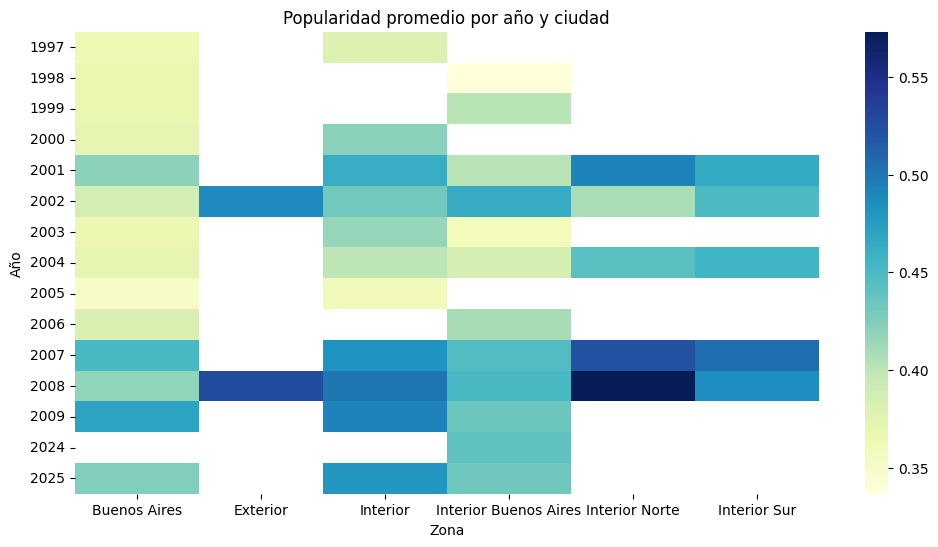

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

tabla = pd.pivot_table(df_conciertos_sin_ineditos, values='indice_popularidad_norm', index='Año', columns='Zona')
plt.figure(figsize=(12,6))
sns.heatmap(tabla, cmap='YlGnBu')
plt.title('Popularidad promedio por año y ciudad')
plt.show()

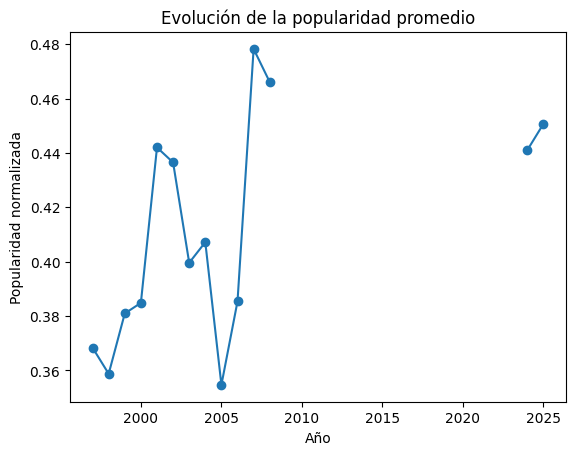

In [28]:
import numpy as np

# Reemplaza los valores entre 2009 y 2023 por NaN para romper la línea
serie = df_conciertos_sin_ineditos.groupby('Año')['indice_popularidad_norm'].mean()
serie_filtrada = serie.copy()
serie_filtrada.loc[serie_filtrada.index.to_series().between(2009, 2023)] = np.nan

serie_filtrada.plot(marker='o')
plt.title('Evolución de la popularidad promedio')
plt.ylabel('Popularidad normalizada')
plt.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image



# Si ya tenés un DataFrame con canciones y su cantidad de veces tocada:
# Supongamos que se llama df_canciones y tiene columnas 'cancion' y 'veces_tocada'

# Expandir la lista 'todas' a partir del DataFrame
todas = []
for idx, row in df_popularidad.iterrows():
    todas.extend([row['canción']] * int(row['veces_tocada']))
    
# Normalizar las canciones para asegurar consistencia
todas = [normalize(song) for song in todas]
# Eliminar duplicados

# Diccionario manual de colores por álbum
album_colors = {
    "Chac Tu Chac": "#694c47",
    "Ay Ay Ay": "#c91a1a",
    "3er Arco": "#f0a924",
    "Azul": "#3476b5",
    "Verde Paisaje del Infierno": "#557346",
    "Maquina de Sangre": "#fa823e",
    "Civilizacion": "#d7c391",
    "Ineditos": "#979c9c"
}

# Asignar color a cada canción según su álbum
color_dict = {}
for song in todas:
    norm_song = normalize(song)
    album = song_to_album.get(norm_song, "Ineditos")
    color_dict[norm_song] = album_colors.get(album, "#000000")




# Ahora, para cada canción, buscamos el color de su álbum
color_dict = {normalize(song): album_colors.get(song_to_album.get(normalize(song), "Ineditos"), "#000000") for song in todas}



def color_asignado(cancion, font_size, position, orientation, font_path, random_state):
    return color_dict.get(cancion, "#000000")



In [65]:
from collections import Counter
from PIL import Image, ImageOps, ImageFilter

los_piojos = r'C:\Users\Yo\AppData\Local\Microsoft\Windows\Fonts\Los_Piojos.ttf'

logo_path = r"C:\Users\Yo\Downloads\576e4d7b40b73db09a3c22973ab3da9f.jpg"

img = Image.open(logo_path).convert("L")
mask = np.array(img)

# 2. Invertí la máscara: palabras SOLO en lo negro
mask = np.where(mask > 128, 0, 255).astype(np.uint8)



# Contar la frecuencia de cada canción
freq = Counter(todas)

# Encontrar las 10 más frecuentes
top_n = 200
top_canciones = [c for c, _ in freq.most_common(top_n)]

# Multiplicar su frecuencia (por ejemplo, x2)
for c in top_canciones:
    freq[c] = int(freq[c] * 2)


In [69]:

wc = WordCloud(
    background_color='white',
    color_func=color_asignado,  # Si ya tenés una función que asigna colores personalizados
    width=1600,
    height=900,
    prefer_horizontal=0.95,
    font_path=los_piojos,  # Podés poner una fuente .ttf si querés una estética especial
    max_words=200,
    min_font_size=10,
    max_font_size=180,
    collocations=False,
    contour_width=1,
    margin=2,
    stopwords=STOPWORDS.union({'de', 'la', 'el'}),  # O ajustá a tus textos
    scale=2,  # Mejora resolución sin cambiar tamaño del archivo final
    normalize_plurals=True,
    repeat=False,
    relative_scaling=0.7,
    mask=mask  # Solo si querés usar una forma personalizada
)

wc.generate_from_frequencies(freq)



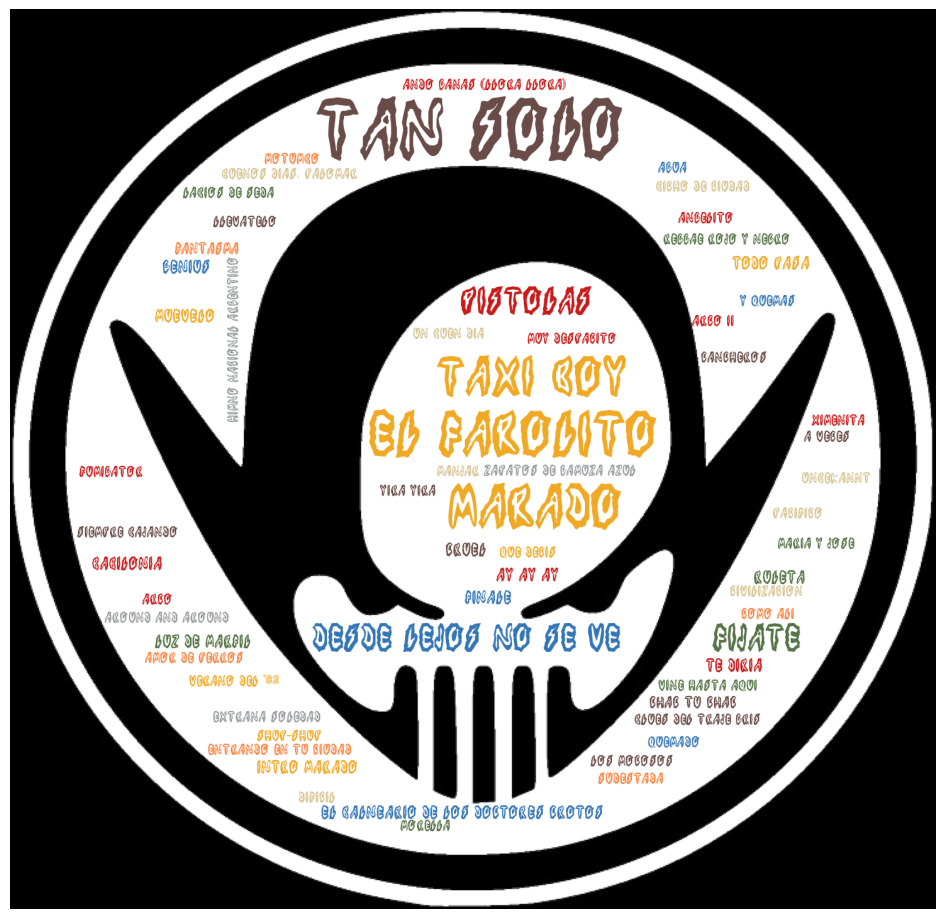

In [70]:
from PIL import Image



# 1. Cargá el logo (JPG, fondo blanco)
logo = Image.open(r"C:\Users\Yo\Downloads\576e4d7b40b73db09a3c22973ab3da9f.jpg").convert("RGBA")
datas = logo.getdata()
wc_img = wc.to_array()
# 2. Hacé transparente el blanco
newData = []
for item in datas:
    # Si es casi blanco, lo hacemos transparente
    if item[0] > 200 and item[1] > 200 and item[2] > 200:
        newData.append((255, 255, 255, 0))
    else:
        newData.append(item)
logo.putdata(newData)

# 3. Redimensioná y superponé como antes
logo = logo.resize((wc_img.shape[1], wc_img.shape[0]))
wc_pil = Image.fromarray(wc_img).convert("RGBA")
final = Image.alpha_composite(wc_pil, logo)

plt.figure(figsize=(16, 9))
plt.imshow(final)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [105]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
import numpy as np

# Elegí las columnas que vas a usar
features = [
    'cantidad_canciones', 'aforo', 'Mes',
    'DíaSemana', 'Estacion', 'Zona'
]

X = df_conciertos_sin_ineditos[features]
y = df_conciertos_sin_ineditos['indice_popularidad_norm']

# Preprocesador para variables categóricas
categorical = ['DíaSemana', 'Estacion', 'Zona']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical)
    ],
    remainder='passthrough'
)

# Pipeline con RandomForest
pipeline = Pipeline([
    ('pre', preprocessor),
    ('reg', RandomForestRegressor(random_state=42))
])

pipeline.fit(X, y)

# Evaluación
from sklearn.metrics import mean_squared_error, r2_score
y_pred = pipeline.predict(X)
print('MSE:', mean_squared_error(y, y_pred))
print('R2:', r2_score(y, y_pred))

MSE: 0.00021621324047820258
R2: 0.9305269994766819


In [106]:
# Ver importancia de las variables
importances = pipeline.named_steps['reg'].feature_importances_
feature_names = preprocessor.get_feature_names_out(features)
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)
print(importance_df)


                            feature  importance
14    remainder__cantidad_canciones    0.324236
15                 remainder__aforo    0.206133
16                   remainder__Mes    0.112826
10               cat__Zona_Interior    0.067324
13           cat__Zona_Interior Sur    0.059626
7           cat__Estacion_Primavera    0.057283
9                cat__Zona_Exterior    0.029062
1           cat__DíaSemana_Saturday    0.020764
2             cat__DíaSemana_Sunday    0.019564
6               cat__Estacion_Otoño    0.018831
11  cat__Zona_Interior Buenos Aires    0.018445
0             cat__DíaSemana_Monday    0.017231
3           cat__DíaSemana_Thursday    0.010945
8              cat__Estacion_Verano    0.010873
12         cat__Zona_Interior Norte    0.010692
4            cat__DíaSemana_Tuesday    0.010328
5          cat__DíaSemana_Wednesday    0.005836


In [113]:
def mejor_combinacion(estacion=None, zona=None, dia_semana=None, aforo=None):
    """    Encuentra la mejor combinación de variables para maximizar la popularidad predicha.
    Args:
        estacion (str): Estación del año (Verano, Otoño, Invierno, Primavera).
        zona (str): Zona geográfica (Buenos Aires, Interior Buenos Aires, Interior, etc.).
        dia_semana (str): Día de la semana (Monday, Tuesday, etc.).
        aforo (int): Aforo del lugar del concierto.
    Returns:
        pd.Series: La mejor combinación de variables con la popularidad predicha.
    """
    # Valores posibles
    dias_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    estaciones = ['Verano', 'Otoño', 'Invierno', 'Primavera']
    zonas = df_conciertos_sin_ineditos['Zona'].cat.categories.tolist()
    aforos = df_conciertos_sin_ineditos['aforo'].unique().tolist()

    # Valores típicos para numéricas
    cantidad_canciones = int(df_conciertos_sin_ineditos['cantidad_canciones'].mean())
    aforo = int(df_conciertos_sin_ineditos['aforo'].max())
    mes = 1

    # Fijar los valores dados, variar los otros
    if estacion is not None:
        estaciones = [estacion]
    if zona is not None:
        zonas = [zona]
    if dia_semana is not None:
        dias_semana = [dia_semana]
    if aforos is not None:
        aforos = [aforo]
    

    # Todas las combinaciones posibles de los libres
    import itertools
    combinaciones = list(itertools.product(dias_semana, estaciones, zonas, festivales))

    # DataFrame de simulación
    df_sim = pd.DataFrame([
        {
            'cantidad_canciones': cantidad_canciones,
            'aforo': aforo,
            'Mes': mes,
            'DíaSemana': dsem,
            'Estacion': est,
            'Zona': z,
        }
        for dsem, est, z, fest in combinaciones
    ])

    # Predecir
    df_sim['popularidad_predicha'] = pipeline.predict(df_sim)
    mejor = df_sim.sort_values('popularidad_predicha', ascending=False).iloc[0]
    return mejor

# Ejemplo de uso:
mejor = mejor_combinacion(dia_semana='Saturday', estacion='Otoño', zona='Buenos Aires',aforo = 80000)
print("Mejor combinación para Verano:")
print(mejor[['Zona', 'DíaSemana', 'cantidad_canciones', 'Mes', 'aforo', 'popularidad_predicha']])

Mejor combinación para Verano:
Zona                    Buenos Aires
DíaSemana                   Saturday
cantidad_canciones                25
Mes                                1
aforo                          80000
popularidad_predicha        0.456042
Name: 0, dtype: object


In [141]:
import pandas as pd
from collections import Counter

# 1. Filtrá shows populares
umbral_top = df_conciertos_sin_ineditos['indice_popularidad_norm'].quantile(0.1)
top_shows = df_conciertos_sin_ineditos[df_conciertos_sin_ineditos['indice_popularidad_norm'] >= umbral_top]

# 2. Expandí a una tabla con canción y posición
records = []
for canciones in top_shows['canciones_show'].dropna():
    for pos, cancion in enumerate(canciones, 1):
        records.append({'cancion': cancion, 'posicion': pos})

df_posiciones = pd.DataFrame(records)
df_posiciones


,cancion,posicion
0,Ximenita,1
1,Taxi Boy,2
2,Babilonia,3
3,Ay ay ay,4
4,Gris,5
...,...,...
3180,El farolito,29
3181,El balneario de los doctores crotos,30
3182,Cruel,31
3183,Finale,32


In [144]:
# 3. Calculá frecuencia y posición promedio
conteo = df_posiciones['cancion'].value_counts()
pos_prom = df_posiciones.groupby('cancion')['posicion'].mean()
conteo.head(30)

cancion
El farolito                            96
Tan solo                               94
Fijate                                 90
Maradó                                 87
Finale                                 84
Desde lejos no se ve                   83
Taxi Boy                               83
Ruleta                                 81
El balneario de los doctores crotos    79
Intro Maradó                           78
Pistolas                               76
Muévelo                                75
Luz de marfil                          73
Genius                                 69
Todo pasa                              69
Cruel                                  68
Ay ay ay                               67
Fantasma                               59
Babilonia                              57
Te diría                               57
Labios de seda                         54
Vine hasta aquí                        53
Pacífico                               51
Chac tu chac              

In [153]:
# 4. Elegí las 18 más frecuentes y ordenalas por posición promedio
top_canciones = conteo.head(30).index
setlist_ideal = pd.DataFrame({
    'cancion': top_canciones,
    'posicion_promedio': pos_prom.loc[top_canciones]
}).sort_values('posicion_promedio')

# 5. Mostralo
import matplotlib.pyplot as plt


setlist_ideal = setlist_ideal.reset_index(drop=True)
setlist_ideal['orden'] = setlist_ideal.index + 1
setlist_ideal[['cancion', 'orden']]

,cancion,orden
0,María y José,1
1,Taxi Boy,2
2,Te diría,3
3,Civilización,4
4,Desde lejos no se ve,5
5,Ay ay ay,6
6,Chac tu chac,7
7,Babilonia,8
8,Labios de seda,9
9,Fantasma,10


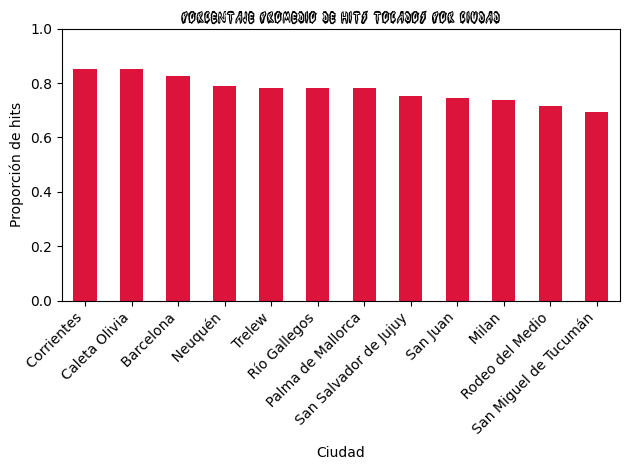

In [163]:
# Definí qué es un "hit" (top 25% más populares)
umbral_hit = df_popularidad['indice_popularidad_norm'].quantile(0.75)
hits = set(df_popularidad[df_popularidad['indice_popularidad_norm'] >= umbral_hit]['cancion_norm'])

def proporcion_hits(canciones):
    if not isinstance(canciones, list) or len(canciones) == 0:
        return 0
    canciones_norm = [normalize(c) for c in canciones]
    return sum(c in hits for c in canciones_norm) / len(canciones_norm)

df_conciertos_sin_ineditos['proporcion_hits'] = df_conciertos_sin_ineditos['canciones_show'].apply(proporcion_hits)

# Agrupá por ciudad (Localidad) y calculá el promedio de hits
hits_por_ciudad = df_conciertos_sin_ineditos.groupby('Localidad')['proporcion_hits'].mean().sort_values(ascending=False)


import matplotlib.pyplot as plt
# Cargar la fuente desde el archivo directamente

import matplotlib.font_manager as fm
fuente_path = r"C:\Users\Yo\AppData\Local\Microsoft\Windows\Fonts\Los_Piojos.ttf"
fuente_prop = fm.FontProperties(fname=fuente_path)

top_n = 12  # Mostrá las 12 ciudades con más shows
ax = hits_por_ciudad.head(top_n).plot(kind='bar', color='crimson')
ax.set_title('Porcentaje promedio de hits tocados por ciudad', fontproperties=fuente_prop)
ax.set_ylabel('Proporción de hits')
ax.set_xlabel('Ciudad')
ax.set_xticklabels(hits_por_ciudad.head(top_n).index, rotation=45, ha='right')
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

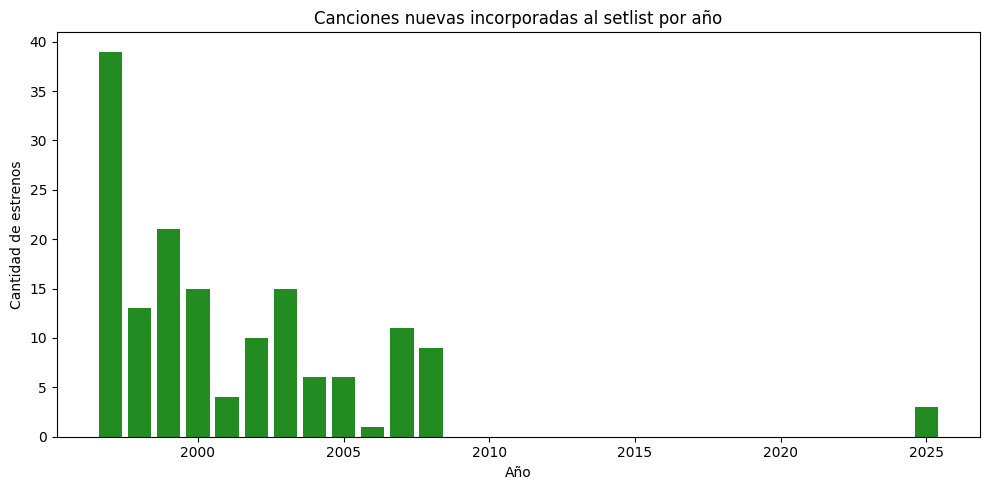

In [164]:
# Para cada año, encontrá las canciones que se tocaron por primera vez
cancion_primera_vez = {}

for idx, row in df_conciertos_sin_ineditos.iterrows():
    año = row['Año']
    canciones = row['canciones_show']
    if not isinstance(canciones, list):
        continue
    for c in canciones:
        if c not in cancion_primera_vez:
            cancion_primera_vez[c] = año

# Armá un DataFrame con año y cantidad de "estrenos"
df_estrenos = pd.Series(list(cancion_primera_vez.values())).value_counts().sort_index()
df_estrenos = df_estrenos.rename_axis('Año').reset_index(name='Canciones nuevas')

# Gráfico de barras
plt.figure(figsize=(10,5))
plt.bar(df_estrenos['Año'], df_estrenos['Canciones nuevas'], color='forestgreen')
plt.title('Canciones nuevas incorporadas al setlist por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de estrenos')
plt.tight_layout()
plt.show()

In [177]:
import plotly.express as px
ciudades_coords = {
    'Concordia': (-31.3929, -58.0189),
    'Avellaneda': (-34.6635, -58.3651),
    'Buenos Aires': (-34.6037, -58.3816),
    'La Plata': (-34.9214, -57.9544),
    'Villa Gesell': (-37.2636, -56.9731),
    'Santa Fe': (-31.6333, -60.7000),
    'Córdoba': (-31.4201, -64.1888),
    'Mar del Plata': (-38.0055, -57.5426),
    'Cosquín': (-31.2483, -64.4564),
    'Galvez': (-32.0281, -61.2208),
    'San Juan': (-31.5375, -68.5364),
    'Mendoza': (-32.8895, -68.8458),
    'La Rioja': (-29.4131, -66.8558),
    'Chascomús': (-35.5725, -58.0092),
    'San Salvador de Jujuy': (-24.1858, -65.2995),
    'Bariloche': (-41.1335, -71.3103),
    'Sauce Viejo': (-31.8167, -60.8333),
    'Paysandú': (-32.3214, -58.0756),
    'San Miguel de Tucumán': (-26.8083, -65.2176),
    'Comodoro Rivadavia': (-45.8647, -67.4822),
    'Bahía Blanca': (-38.7196, -62.2724),
    'Rosario': (-32.9468, -60.6393),
    'Palma de Mallorca': (39.5696, 2.6502),
    'Río Grande': (-53.7877, -67.7095),
    'Salta': (-24.7821, -65.4232),
    'Rodeo del Medio': (-32.9833, -68.6833),
    'Villa María': (-32.4075, -63.2406),
    'Río Gallegos': (-51.6230, -69.2168),
    'Trelew': (-43.2489, -65.3051),
    'Olavarría': (-36.8927, -60.3225),
    'Neuquén': (-38.9516, -68.0591),
    'Barcelona': (41.3851, 2.1734),
    'Milan': (45.4642, 9.1900),
    'Corrientes': (-27.4692, -58.8306),
    'Caleta Olivia': (-46.4444, -67.5281),
    'Santa Maria de Punilla': (-31.2776, -64.4927),
    'Villa Martelli': (-34.5456, -58.5236)
}
# Armá el DataFrame para el mapa
df_map = hits_por_ciudad.reset_index().rename(columns={'Localidad': 'Ciudad'})
df_map['lat'] = df_map['Ciudad'].map(lambda x: ciudades_coords.get(x.strip(), (None, None))[0])
df_map['lon'] = df_map['Ciudad'].map(lambda x: ciudades_coords.get(x.strip(), (None, None))[1])
df_map = df_map.dropna(subset=['lat', 'lon'])

fig = px.scatter_mapbox(
    df_map,
    lat="lat",
    lon="lon",
    size="proporcion_hits",
    color="proporcion_hits",
    color_continuous_scale=px.colors.sequential.OrRd,
    size_max=30,
    zoom=3,
    hover_name="Ciudad",
    hover_data={"proporcion_hits":":.2f",
                "lat": False, "lon": False
                },
    title="Porcentaje promedio de hits tocados por ciudad"
)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

In [172]:
df_conciertos_sin_ineditos['Localidad'].unique()

array([' Concordia', ' Avellaneda', ' Buenos Aires', ' La Plata',
       ' Villa Gesell', ' Santa Fe', ' Córdoba', ' Mar del Plata',
       ' Cosquín', ' Galvez', ' San Juan', ' Mendoza', ' La Rioja',
       ' Chascomús', ' San Salvador de Jujuy', ' Bariloche',
       ' Sauce Viejo', ' Paysandú', ' San Miguel de Tucumán',
       ' Comodoro Rivadavia', ' Bahía Blanca', ' Rosario',
       ' Palma de Mallorca', ' Río Grande', ' Salta', ' Rodeo del Medio',
       ' Villa María', ' Río Gallegos', ' Trelew', ' Olavarría',
       ' Neuquén', ' Barcelona', ' Milan', ' Corrientes',
       ' Caleta Olivia', ' Santa Maria de Punilla', ' Villa Martelli'],
      dtype=object)

In [170]:
import plotly.graph_objects as go

# Armá los nodos (años y canciones nuevas)
estrenos = []
for idx, row in df_conciertos_sin_ineditos.iterrows():
    año = row['Año']
    canciones = row['canciones_show']
    if not isinstance(canciones, list):
        continue
    for c in canciones:
        if c not in cancion_primera_vez:
            cancion_primera_vez[c] = año
            estrenos.append((año, c))

# Nodos: años + canciones
anios = sorted(set(a for a, _ in estrenos))
canciones = [c for _, c in estrenos]
labels = [str(a) for a in anios] + canciones

# Links
source = []
target = []
value = []
for a, c in estrenos:
    source.append(labels.index(str(a)))
    target.append(labels.index(c))
    value.append(1)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=labels,
        color="green"
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ))])

fig.update_layout(title_text="Evolución de canciones nuevas por año (Sankey)", font_size=10)
fig.show()